Scaler loaded from scaler.joblib
Recording for 1.0 second(s)... Speak now!
Recording saved as recorded_audio_cell.wav
Trimmed audio saved as trimmed_audio.wav
Processing trimmed_audio.wav for prediction...
Loading pre-trained model...
Predicting digit...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step

--->>> PREDICTED DIGIT: 9


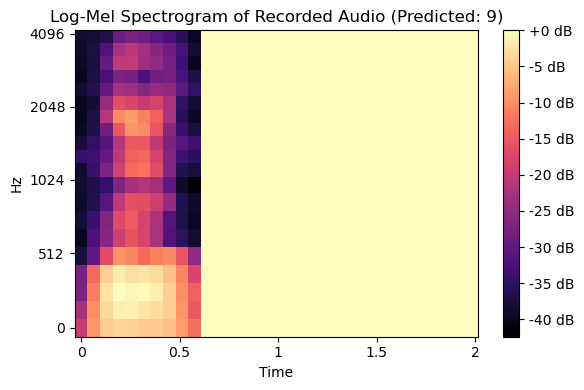

In [31]:
import sounddevice as sd
from scipy.io.wavfile import write as write_wav
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt 
import librosa
import librosa.display 
import joblib

def trim_silence(audio_data, sr, threshold_db=-15, min_silence_duration=0.1):
    if len(audio_data.shape) > 1:
        audio_data = audio_data[:, 0]
    
    amplitude = np.abs(audio_data)
    max_amplitude = np.max(amplitude)
    if max_amplitude > 0:
        # Add small epsilon to prevent divide by zero
        db = 20 * np.log10(np.maximum(amplitude, 1e-10) / max_amplitude)
    else:
        return audio_data
    
    non_silence = db > threshold_db
    
    non_silence_frames = np.where(non_silence)[0]
    if len(non_silence_frames) > 0:
        start_idx = non_silence_frames[0]
        end_idx = non_silence_frames[-1] + 1
        
        buffer_samples = int(min_silence_duration * sr)
        start_idx = max(0, start_idx - buffer_samples)
        end_idx = min(len(audio_data), end_idx + buffer_samples)
        
        return audio_data[start_idx:end_idx]
    else:
        return audio_data

def stretch_to_duration(wave, orig_sr, target_duration=0.5):
    target_length = int(target_duration * orig_sr)
    current_length = len(wave)
    
    if current_length == 0:
        return np.zeros(target_length)
    
    if current_length < target_length:
        return librosa.effects.time_stretch(wave, rate=current_length/target_length)
    else:
        return librosa.effects.time_stretch(wave, rate=current_length/target_length)

def wav2logmelspec2(file_path, max_pad_len=32):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    #wave = stretch_to_duration(wave, orig_sr=sr, target_duration=0.75)
    wave = librosa.resample(wave, orig_sr=sr, target_sr=8000) 
    melspec = librosa.feature.melspectrogram(y=wave,
                                             sr=8000,
                                             n_fft=2048,
                                             hop_length=512,
                                             n_mels=20)
    log_mel_spec = librosa.power_to_db(melspec, ref=np.max)

    current_len = log_mel_spec.shape[1]
    if current_len > max_pad_len:
        log_mel_spec = log_mel_spec[:, :max_pad_len]
    elif current_len < max_pad_len:
        pad_width = max_pad_len - current_len
        log_mel_spec = np.pad(log_mel_spec, pad_width=((0, 0), (0, pad_width)), mode='constant')

    return log_mel_spec

def record_audio_for_notebook_cell(duration_sec=1, rate_hz=48000, output_filename="recorded_audio_cell.wav"):
    print(f"Recording for {duration_sec} second(s)... Speak now!")
    audio_recording = sd.rec(int(duration_sec * rate_hz), samplerate=rate_hz, channels=1, dtype='float32')
    sd.wait()
    write_wav(output_filename, rate_hz, audio_recording)
    print(f"Recording saved as {output_filename}")
    return output_filename, audio_recording

def trim_and_save_audio(audio_data, sr, output_filename="trimmed_audio.wav"):
    trimmed_audio = trim_silence(audio_data, sr)
    write_wav(output_filename, sr, trimmed_audio)
    print(f"Trimmed audio saved as {output_filename}")
    return output_filename

def preprocess_single_audio_for_model(audio_file_path_str, scaler_object, model_steps=32, model_mels=20):
    log_mel_spectrogram = wav2logmelspec2(audio_file_path_str) 
    flattened_log_mel = log_mel_spectrogram.reshape(1, -1)
    scaled_flattened_log_mel = scaler_object.transform(flattened_log_mel)
    model_input_shape_tuple = (1, model_steps, model_mels) 
    final_processed_audio = scaled_flattened_log_mel.reshape(model_input_shape_tuple)
    return final_processed_audio, log_mel_spectrogram 

def predict_digit_from_audio_cell(audio_file_path_str, model_file_path_str, scaler_object):
    print(f"Processing {audio_file_path_str} for prediction...")
    processed_model_features, raw_log_mel_spec_for_plot = preprocess_single_audio_for_model(audio_file_path_str, scaler_object, model_steps=32, model_mels=20)
    
    print("Loading pre-trained model...")
    keras_model = load_model(model_file_path_str, compile=False) 

    print("Predicting digit...")
    model_prediction = keras_model.predict(processed_model_features)
    predicted_class_index = np.argmax(model_prediction, axis=1)[0]
    
    return predicted_class_index, raw_log_mel_spec_for_plot, processed_model_features

model_save_path = "logmel_lstm_digit_classifier.h5"
scaler = joblib.load("scaler.joblib")
print(f"Scaler loaded from scaler.joblib")

filename_of_recording, audio_data = record_audio_for_notebook_cell(duration_sec=1.0)
filename_of_recording = trim_and_save_audio(audio_data, sr=48000)
result_predicted_digit, spectrogram_to_plot, processed_features = predict_digit_from_audio_cell(filename_of_recording, model_save_path, scaler)

print(f"\n--->>> PREDICTED DIGIT: {result_predicted_digit}")

plt.figure(figsize=(6, 4))
librosa.display.specshow(spectrogram_to_plot, sr=8000, hop_length=512, x_axis='time', y_axis='mel')
plt.title(f'Log-Mel Spectrogram of Recorded Audio (Predicted: {result_predicted_digit})')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()